In [ ]:
pip install geopy

4.3352859803313555


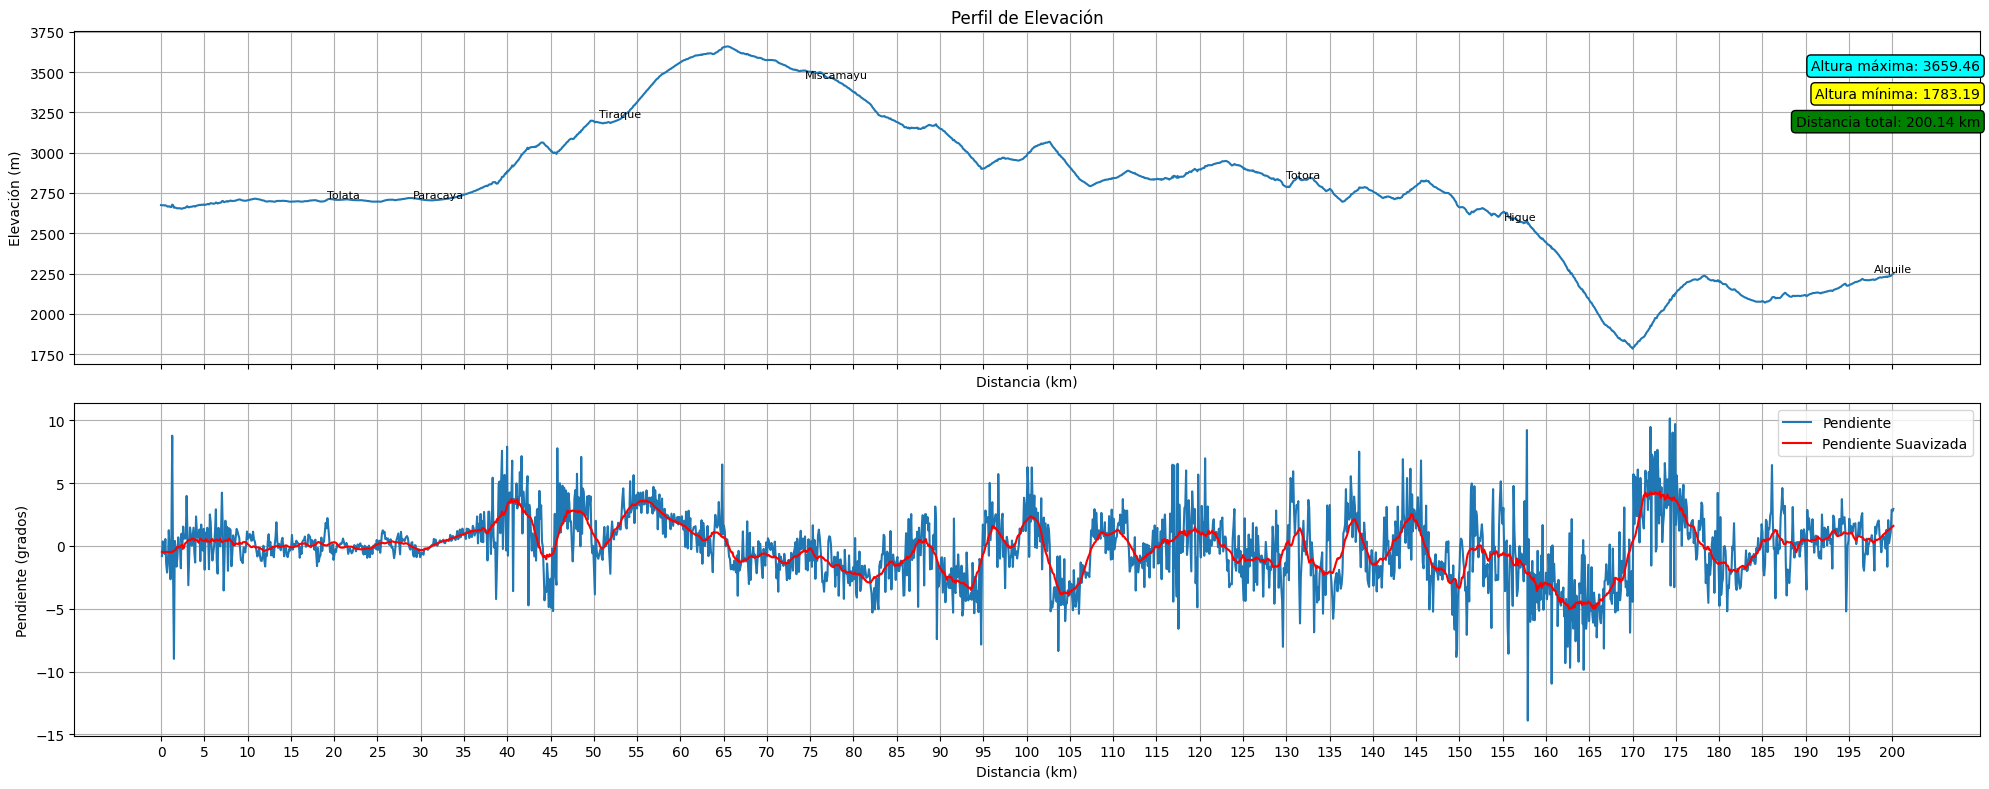

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, sqrt, atan2, radians, degrees, tan, atan
from scipy.signal import savgol_filter
from geopy.geocoders import Nominatim


class ElevationProfile():
  def __init__(self,data, locations):
      self.data = data
      self.locations = locations
      self.lats = 0
      self.lons = 0
      self.slopes = 0
      self.slopes_smooth = 0
      self.process_data()

  def process_data(self):
        # Extraer lats y lons
        self.lats = [p['location']['lat'] for p in self.data['elevations']]
        self.lons = [p['location']['lng'] for p in self.data['elevations']]

        # Convertir a metros
        self.x, self.y = self.gps_to_meters(self.lons, self.lats)

        # Calcular distancias y elevaciones
        self.distances, self.elevations = [0], []
        for i in range(1, len(self.data['elevations'])):
            self.calculate_distance_elevation(i)

        # Quitar último elemento de distances
        self.distances = self.distances[:-1]

        # Calcular pendientes
        self.elev_diff = np.diff(self.elevations)
        self.dist_diff = np.diff(self.distances) * 1000
        self.slopes = np.degrees(np.arctan2(self.elev_diff, self.dist_diff))

        # Suavizar pendientes
        window = 25
        self.slopes_smooth = savgol_filter(self.slopes, window, 1)

        # Calcular pendiente máxima
        self.max_slope = np.max(self.slopes_smooth)
  def gps_to_meters(self, long, lat):
      R_E = 6.3781 * 10 ** 6
      lat2meter = 111.3199 * 10 ** 3
      equator_circ = 2 * R_E * np.pi

      x, y = [0], [0]
      for i in range(len(long) - 1):
          long_m = (long[i + 1] - long[i]) * equator_circ * np.cos(np.deg2rad(lat[i + 1])) / 360 + x[-1]
          x.append(long_m)
          y.append((lat[i + 1] - lat[i]) * lat2meter + y[-1])
      return x, y


  def calculate_distance_elevation(self, i):
        lat1, lon1 = self.lats[i-1], self.lons[i-1]
        lat2, lon2 = self.lats[i], self.lons[i]
        dlat, dlon = radians(lat2 - lat1), radians(lon2 - lon1)

        a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        d = 6371 * c

        distance = self.distances[-1] + d
        self.distances.append(distance)
        self.elevations.append(self.data['elevations'][i]['elevation'])
  def curvature_cal(x, y):
    z = np.zeros(len(x))
    track = np.transpose(np.array([x, y, z]))
    L, curvature, k = [0], [0], np.array([[0, 0, 0]])

    for i in range(len(x) - 2):
        R, k_i = circumcenter(track[i, :], track[i + 1, :], track[i + 2, :])
        k = np.append(k, [np.transpose(k_i)], axis=0)
        L.append(L[i] + np.linalg.norm(track[i, :] - track[i - 1, :]))
        sign = np.sign(np.cross(track[i + 1, :] - track[i, :], k_i)[2])
        curvature.append(R ** (-1) * sign * (-1))

    return L, curvature, k
  def plot(self):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), sharex=True)

    ax1.plot(self.distances,self.elevations)
    ax1.set_title('Perfil de Elevación')
    ax1.set_xlabel('Distancia (km)')
    ax1.set_ylabel('Elevación (m)')
    ax1.grid()

    ax2.plot(self.distances[1:], self.slopes, label='Pendiente')
    ax2.plot(self.distances[1:], self.slopes_smooth, color='red', label='Pendiente Suavizada')
    ax2.legend()
    ax2.set_xlabel('Distancia (km)')
    ax2.set_ylabel('Pendiente (grados)')
    ax2.set_xticks(np.arange(0, self.distances[-1], 5))
    ax2.grid()

    # Annotate maximum and minimum elevations
    max_elev = max(self.elevations)
    min_elev = min(self.elevations)
    dist_text = 'Distancia total: ' + str(round(self.distances[-1], 2)) + ' km'
    ax1.annotate('Altura máxima: ' + str(round(max_elev, 2)), xy=(1, 1), xycoords='axes fraction', xytext=(0, -20),
                textcoords='offset points', ha='right', va='top', bbox=dict(boxstyle='round', fc='cyan'))
    ax1.annotate('Altura mínima: ' + str(round(min_elev, 2)), xy=(1, 1), xycoords='axes fraction', xytext=(0, -40),
                textcoords='offset points', ha='right', va='top', bbox=dict(boxstyle='round', fc='yellow'))
    ax1.annotate(dist_text, xy=(1, 1), xycoords='axes fraction', xytext=(0, -60), textcoords='offset points', ha='right',
                va='top', bbox=dict(boxstyle='round', fc='green'))


    for name, distance in self.locations.items():
        idx = np.argmin(np.abs(np.array(self.distances) - distance))
        ax1.text(self.distances[idx], self.elevations[idx], name, ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    with open('/content/datos.txt') as f:
        data = json.load(f)

    locations1 = {'Tolata': 21, 'Paracaya': 32, 'Tiraque': 53, 'Miscamayu': 78, 'Totora': 132, 'Higue': 157, 'Alquile': 200}
    profile = ElevationProfile(data, locations1)
    print(profile.max_slope)
    profile.plot()


# Prueba codigo


<ipython-input-88-a01b537eeb30>:66: RuntimeWarning: invalid value encountered in true_divide
  G = (b**2*E-c**2*F)/np.linalg.norm(D)**2/2


Pendiente máxima: 4.34 grados


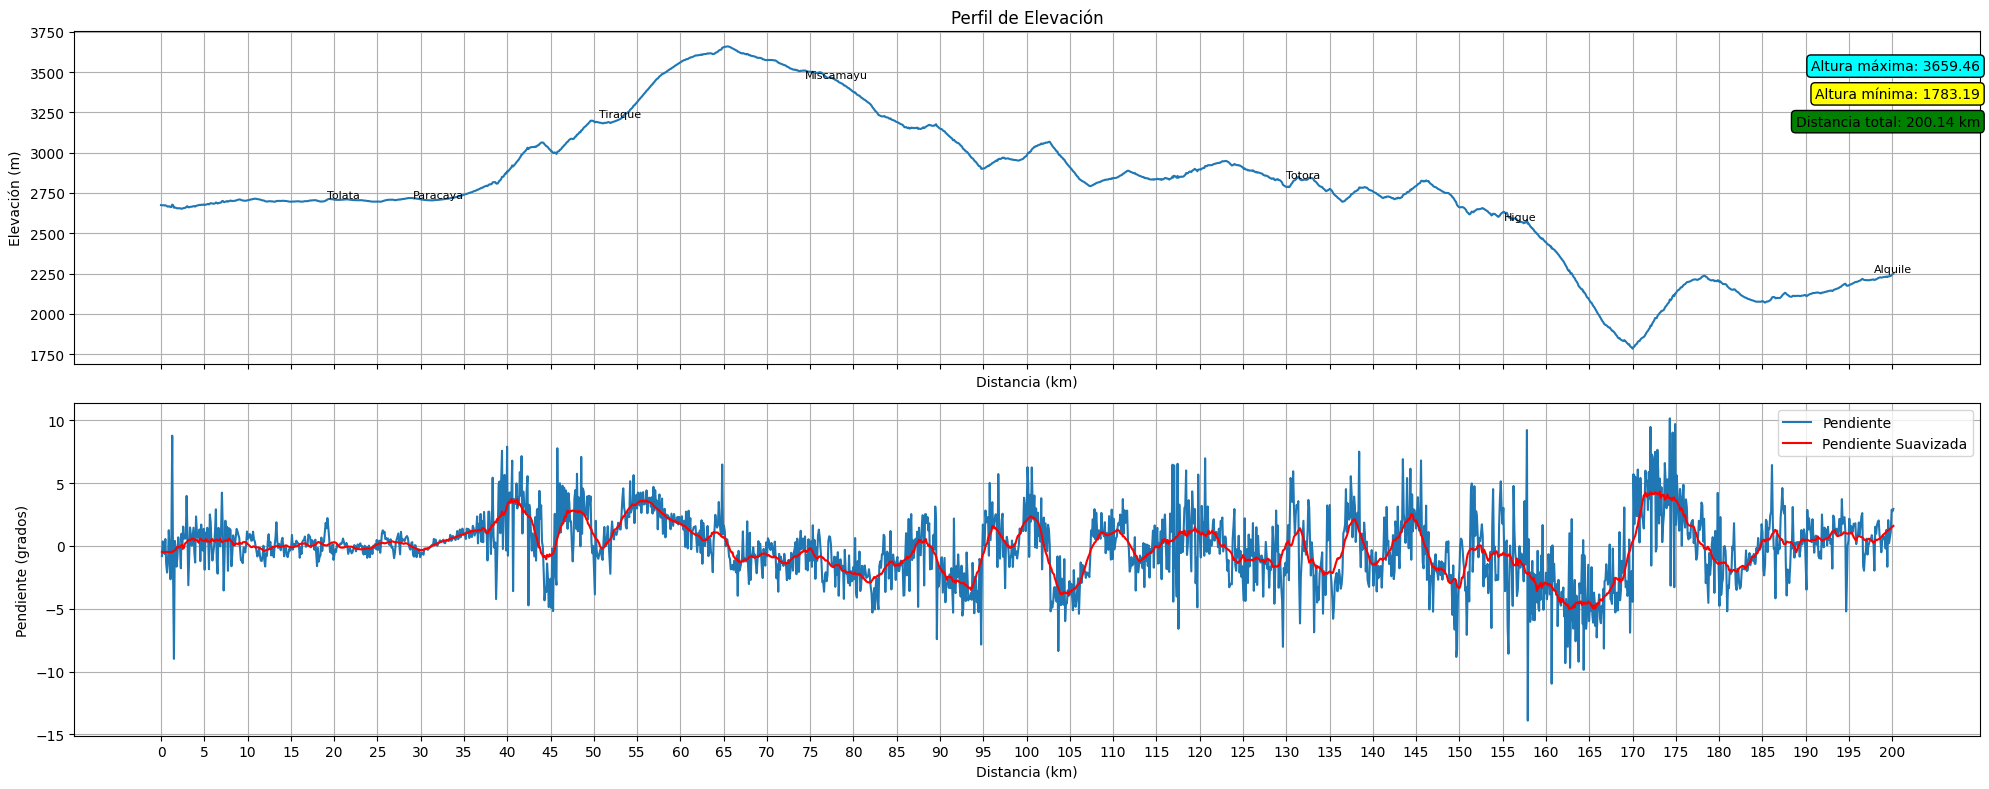

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, sqrt, atan2, radians, degrees, tan, atan
from scipy.signal import savgol_filter
from geopy.geocoders import Nominatim

def find_assistance_points(distances, slopes, battery_range):

  assistance_points = []
  remaining_range = battery_range

  start_idx = 0
  uphill_dist = 0

  for i in range(len(distances)-1):

    if slopes[i] <= 0 or slopes[i] < 1:
      # Reiniciar distancia si pendiente es <= 0 o < 2 grados
      start_idx = i+1
      uphill_dist = 0

    else:
      uphill_dist += distances[i] - distances[start_idx]

      if uphill_dist >= 1 and remaining_range < distances[-1] - distances[i]:
         assistance_points.append(i)
         remaining_range = battery_range - (distances[-1] - distances[i])

  return assistance_points

def suggest_relay_points(distances, interval=10):
    relay_points = []
    dist_covered = 0

    for i in range(len(distances)):
        if dist_covered >= interval:
            relay_points.append(i)
            dist_covered = 0

        dist_covered += distances[i] - distances[i-1]

    return relay_points

def gps2meter(long, lat):
    R_E = 6.3781 * 10 ** 6
    lat2meter = 111.3199 * 10 ** 3
    equator_circ = 2 * R_E * np.pi

    x, y = [0], [0]
    for i in range(len(long) - 1):
        long_m = (long[i + 1] - long[i]) * equator_circ * np.cos(np.deg2rad(lat[i + 1])) / 360 + x[-1]
        x.append(long_m)
        y.append((lat[i + 1] - lat[i]) * lat2meter + y[-1])

    return x, y

def curvature_cal(x, y):
    z = np.zeros(len(x))
    track = np.transpose(np.array([x, y, z]))
    L, curvature, k = [0], [0], np.array([[0, 0, 0]])

    for i in range(len(x) - 2):
        R, k_i = circumcenter(track[i, :], track[i + 1, :], track[i + 2, :])
        k = np.append(k, [np.transpose(k_i)], axis=0)
        L.append(L[i] + np.linalg.norm(track[i, :] - track[i - 1, :]))
        sign = np.sign(np.cross(track[i + 1, :] - track[i, :], k_i)[2])
        curvature.append(R ** (-1) * sign * (-1))

    return L, curvature, k


with open('/content/datos.txt') as f:
    data = json.load(f)


lats = [p['location']['lat'] for p in data['elevations']]
lons = [p['location']['lng'] for p in data['elevations']]


x, y = gps2meter(lons, lats)


distances, elevations = [0], []
for i in range(1, len(data['elevations'])):
    lat1, lon1 = lats[i - 1], lons[i - 1]
    lat2, lon2 = lats[i], lons[i]
    dlat, dlon = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    d = 6371 * c
    distance = distances[-1] + d
    distances.append(distance)
    elevations.append(data['elevations'][i]['elevation'])

distances = distances[:-1]

_, curvatures, k = curvature_cal(x, y)


elev_diff = np.diff(elevations)
dist_diff = np.diff(distances) * 1000
slopes = np.degrees(np.arctan2(elev_diff, dist_diff))

window = 25
slopes_smooth = savgol_filter(slopes, window, 1)


max_slope = np.max(slopes_smooth)
print(f"Pendiente máxima: {max_slope:.2f} grados")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
ax1.plot(distances, elevations)


#------------------------------
ax1.set_title('Perfil de Elevación')
ax1.set_xlabel('Distancia (km)')
ax1.set_ylabel('Elevación (m)')
ax1.grid()

ax2.plot(distances[1:], slopes, label='Pendiente')
ax2.plot(distances[1:], slopes_smooth, color='red', label='Pendiente Suavizada')
ax2.legend()
ax2.set_xlabel('Distancia (km)')
ax2.set_ylabel('Pendiente (grados)')
ax2.set_xticks(np.arange(0, distances[-1], 5))
ax2.grid()


max_elev = max(elevations)
min_elev = min(elevations)
dist_text = 'Distancia total: ' + str(round(distances[-1], 2)) + ' km'
ax1.annotate('Altura máxima: ' + str(round(max_elev, 2)), xy=(1, 1), xycoords='axes fraction', xytext=(0, -20),
             textcoords='offset points', ha='right', va='top', bbox=dict(boxstyle='round', fc='cyan'))
ax1.annotate('Altura mínima: ' + str(round(min_elev, 2)), xy=(1, 1), xycoords='axes fraction', xytext=(0, -40),
             textcoords='offset points', ha='right', va='top', bbox=dict(boxstyle='round', fc='yellow'))
ax1.annotate(dist_text, xy=(1, 1), xycoords='axes fraction', xytext=(0, -60), textcoords='offset points', ha='right',
             va='top', bbox=dict(boxstyle='round', fc='green'))

'''
# Anotar ubicaciones automáticamente
geolocator = Nominatim(user_agent="localidades_cercanas")

for distance in locations.values():
    idx = np.argmin(np.abs(np.array(distances) - distance))
    lat, lon = lats[idx], lons[idx]
    location = geolocator.reverse((lat, lon), exactly_one=True)
    if location:
        address = location.raw.get('address', {})
        municipality = address.get('city') or address.get('town') or address.get('village') or address.get('country')
        if municipality:
            ax1.text(distances[idx], elevations[idx], municipality, ha='center', va='bottom', fontsize=8)
'''
locations = {'Tolata': 21, 'Paracaya': 32, 'Tiraque': 53, 'Miscamayu': 78, 'Totora': 132, 'Higue': 157, 'Alquile': 200}
for name, distance in locations.items():
    idx = np.argmin(np.abs(np.array(distances) - distance))
    ax1.text(distances[idx], elevations[idx], name, ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


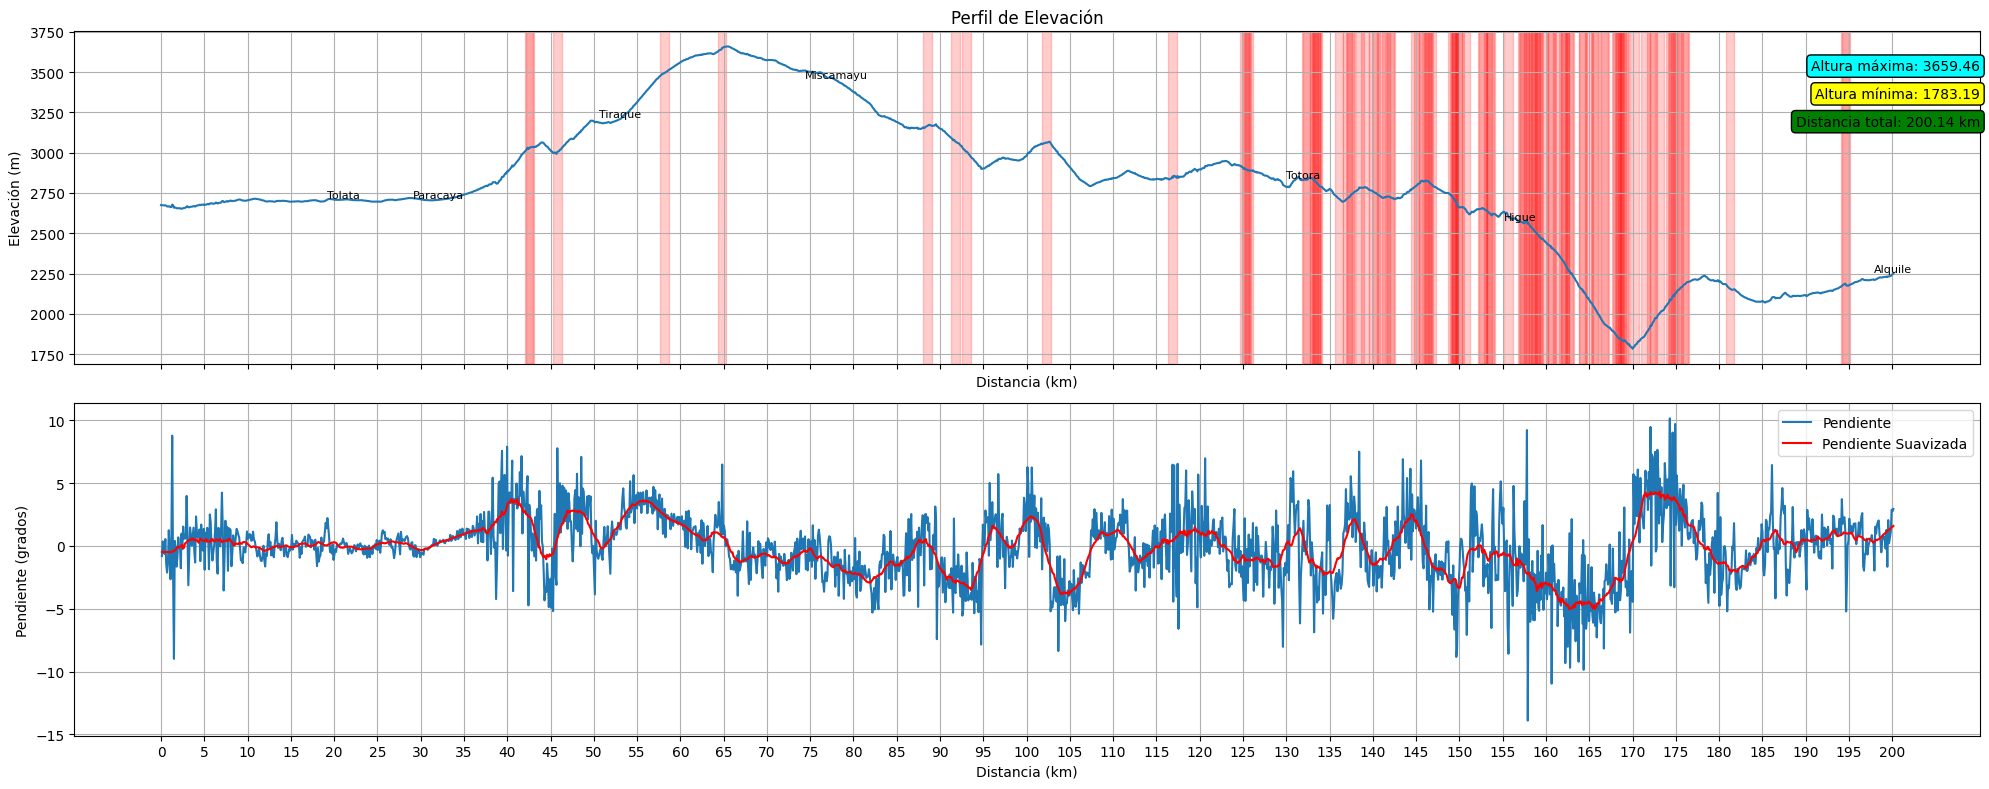

In [ ]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
ax1.plot(distances, elevations)
for i, c in enumerate(curvatures):
    if abs(c) > 0.01:  # umbral de curvatura
        ax1.axvspan(distances[i - 5], distances[i + 5], alpha=0.2, color='red')

#-------------------


#------------------------------
ax1.set_title('Perfil de Elevación')
ax1.set_xlabel('Distancia (km)')
ax1.set_ylabel('Elevación (m)')
ax1.grid()

ax2.plot(distances[1:], slopes, label='Pendiente')
ax2.plot(distances[1:], slopes_smooth, color='red', label='Pendiente Suavizada')
ax2.legend()
ax2.set_xlabel('Distancia (km)')
ax2.set_ylabel('Pendiente (grados)')
ax2.set_xticks(np.arange(0, distances[-1], 5))
ax2.grid()


max_elev = max(elevations)
min_elev = min(elevations)
dist_text = 'Distancia total: ' + str(round(distances[-1], 2)) + ' km'
ax1.annotate('Altura máxima: ' + str(round(max_elev, 2)), xy=(1, 1), xycoords='axes fraction', xytext=(0, -20),
             textcoords='offset points', ha='right', va='top', bbox=dict(boxstyle='round', fc='cyan'))
ax1.annotate('Altura mínima: ' + str(round(min_elev, 2)), xy=(1, 1), xycoords='axes fraction', xytext=(0, -40),
             textcoords='offset points', ha='right', va='top', bbox=dict(boxstyle='round', fc='yellow'))
ax1.annotate(dist_text, xy=(1, 1), xycoords='axes fraction', xytext=(0, -60), textcoords='offset points', ha='right',
             va='top', bbox=dict(boxstyle='round', fc='green'))

'''
# Anotar ubicaciones automáticamente
geolocator = Nominatim(user_agent="localidades_cercanas")

for distance in locations.values():
    idx = np.argmin(np.abs(np.array(distances) - distance))
    lat, lon = lats[idx], lons[idx]
    location = geolocator.reverse((lat, lon), exactly_one=True)
    if location:
        address = location.raw.get('address', {})
        municipality = address.get('city') or address.get('town') or address.get('village') or address.get('country')
        if municipality:
            ax1.text(distances[idx], elevations[idx], municipality, ha='center', va='bottom', fontsize=8)
'''
locations = {'Tolata': 21, 'Paracaya': 32, 'Tiraque': 53, 'Miscamayu': 78, 'Totora': 132, 'Higue': 157, 'Alquile': 200}
for name, distance in locations.items():
    idx = np.argmin(np.abs(np.array(distances) - distance))
    ax1.text(distances[idx], elevations[idx], name, ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

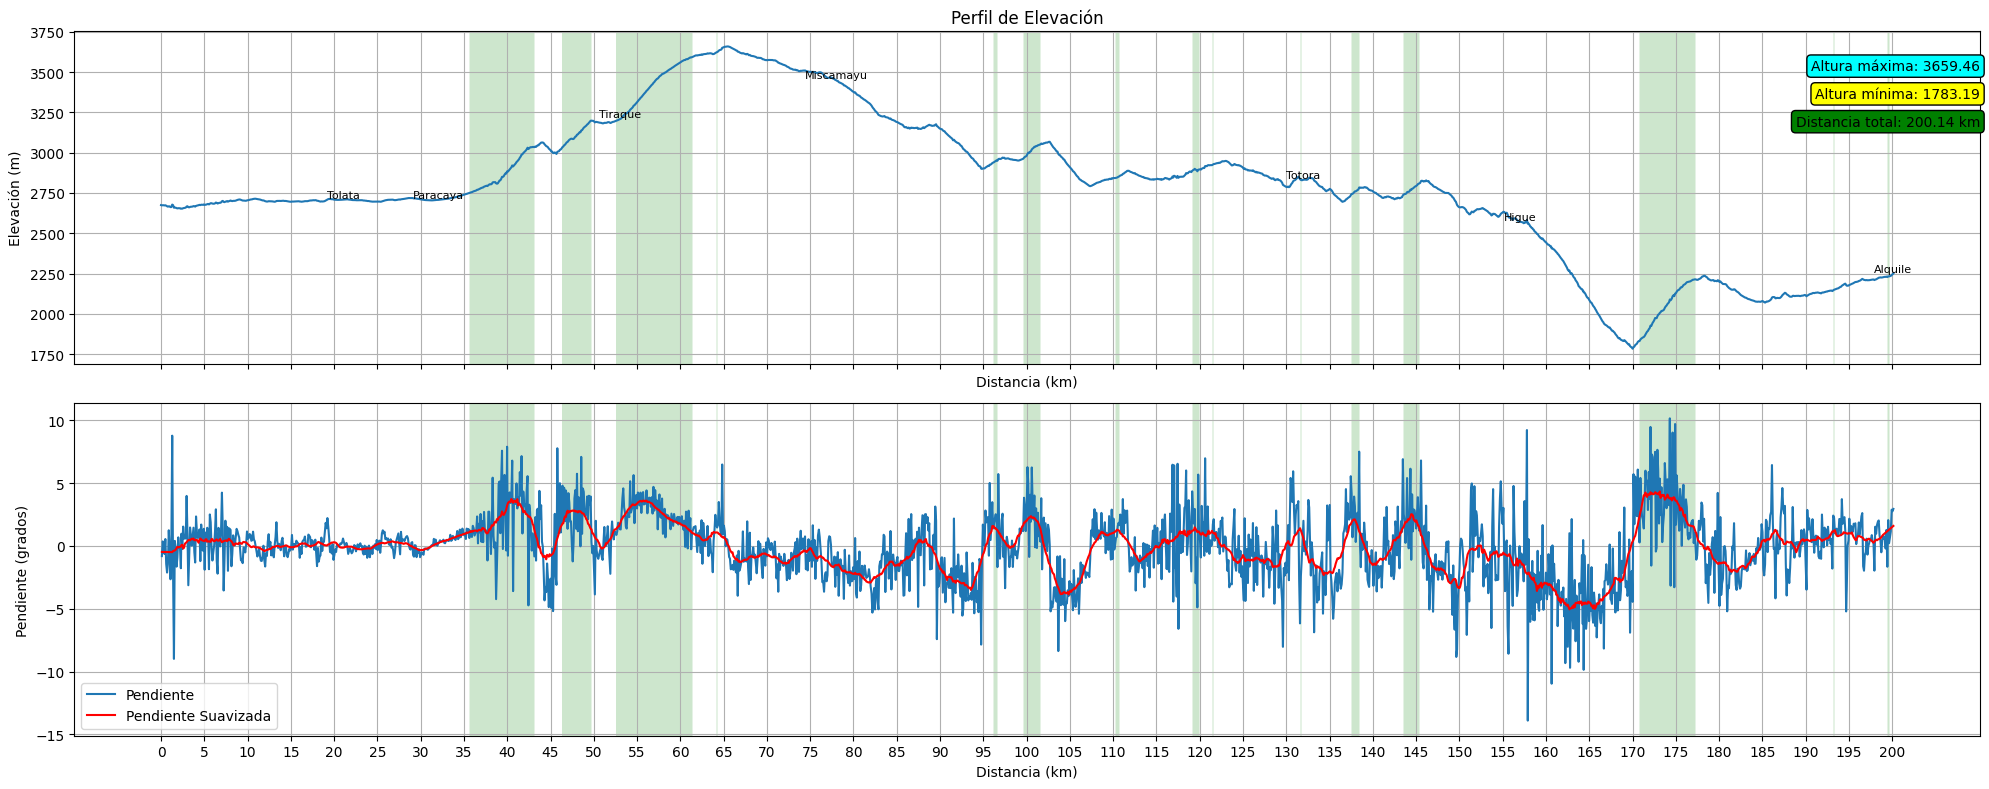

In [ ]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
ax1.plot(distances, elevations)


battery_range = 1
assist_points = find_assistance_points(distances, slopes_smooth, battery_range)


relay_points = suggest_relay_points(distances, 30)

for i in relay_points:
   ax1.axvspan(distances[i-5], distances[i+5], facecolor='green', alpha=0.1)



for i in assist_points:
   ax1.axvspan(distances[i-1], distances[i+1], facecolor='green', alpha=0.1)
   ax2.axvspan(distances[i-1], distances[i+1], facecolor='green', alpha=0.1)

#------------------------------
ax1.set_title('Perfil de Elevación')
ax1.set_xlabel('Distancia (km)')
ax1.set_ylabel('Elevación (m)')
ax1.grid()

ax2.plot(distances[1:], slopes, label='Pendiente')
ax2.plot(distances[1:], slopes_smooth, color='red', label='Pendiente Suavizada')
ax2.legend()
ax2.set_xlabel('Distancia (km)')
ax2.set_ylabel('Pendiente (grados)')
ax2.set_xticks(np.arange(0, distances[-1], 5))
ax2.grid()

# Annotate maximum and minimum elevations
max_elev = max(elevations)
min_elev = min(elevations)
dist_text = 'Distancia total: ' + str(round(distances[-1], 2)) + ' km'
ax1.annotate('Altura máxima: ' + str(round(max_elev, 2)), xy=(1, 1), xycoords='axes fraction', xytext=(0, -20),
             textcoords='offset points', ha='right', va='top', bbox=dict(boxstyle='round', fc='cyan'))
ax1.annotate('Altura mínima: ' + str(round(min_elev, 2)), xy=(1, 1), xycoords='axes fraction', xytext=(0, -40),
             textcoords='offset points', ha='right', va='top', bbox=dict(boxstyle='round', fc='yellow'))
ax1.annotate(dist_text, xy=(1, 1), xycoords='axes fraction', xytext=(0, -60), textcoords='offset points', ha='right',
             va='top', bbox=dict(boxstyle='round', fc='green'))

'''
# Anotar ubicaciones automáticamente
geolocator = Nominatim(user_agent="localidades_cercanas")

for distance in locations.values():
    idx = np.argmin(np.abs(np.array(distances) - distance))
    lat, lon = lats[idx], lons[idx]
    location = geolocator.reverse((lat, lon), exactly_one=True)
    if location:
        address = location.raw.get('address', {})
        municipality = address.get('city') or address.get('town') or address.get('village') or address.get('country')
        if municipality:
            ax1.text(distances[idx], elevations[idx], municipality, ha='center', va='bottom', fontsize=8)
'''
locations = {'Tolata': 21, 'Paracaya': 32, 'Tiraque': 53, 'Miscamayu': 78, 'Totora': 132, 'Higue': 157, 'Alquile': 200}
for name, distance in locations.items():
    idx = np.argmin(np.abs(np.array(distances) - distance))
    ax1.text(distances[idx], elevations[idx], name, ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
import folium
# Calcular puntos de curva
high_curvature_points = []

for i, c in enumerate(curvatures):
   if abs(c) > 0.01:
      high_curvature_points.append(i)
# Crear mapa centrado en el punto medio
lat_mean = np.mean(lats)
lon_mean = np.mean(lons)
map = folium.Map(location=[lat_mean, lon_mean], zoom_start=13)

# Agregar puntos del recorrido
for lat, lon in zip(lats, lons):
    folium.CircleMarker([lat, lon],
                        radius=1,
                        color='blue',
                        fill=True).add_to(map)

# Agregar puntos de asistencia
for i in assist_points:
   folium.CircleMarker([lats[i], lons[i]],
                       radius=3,
                       color='green',
                       fill=True).add_to(map)
 # Agregar puntos de curva
for i in high_curvature_points:
   folium.CircleMarker([lats[i], lons[i]],
                       radius=4,
                       color='red',
                       fill=True).add_to(map)
# Guardar mapa html
map.save('mapa.html')

Pendiente máxima: 4.59 grados


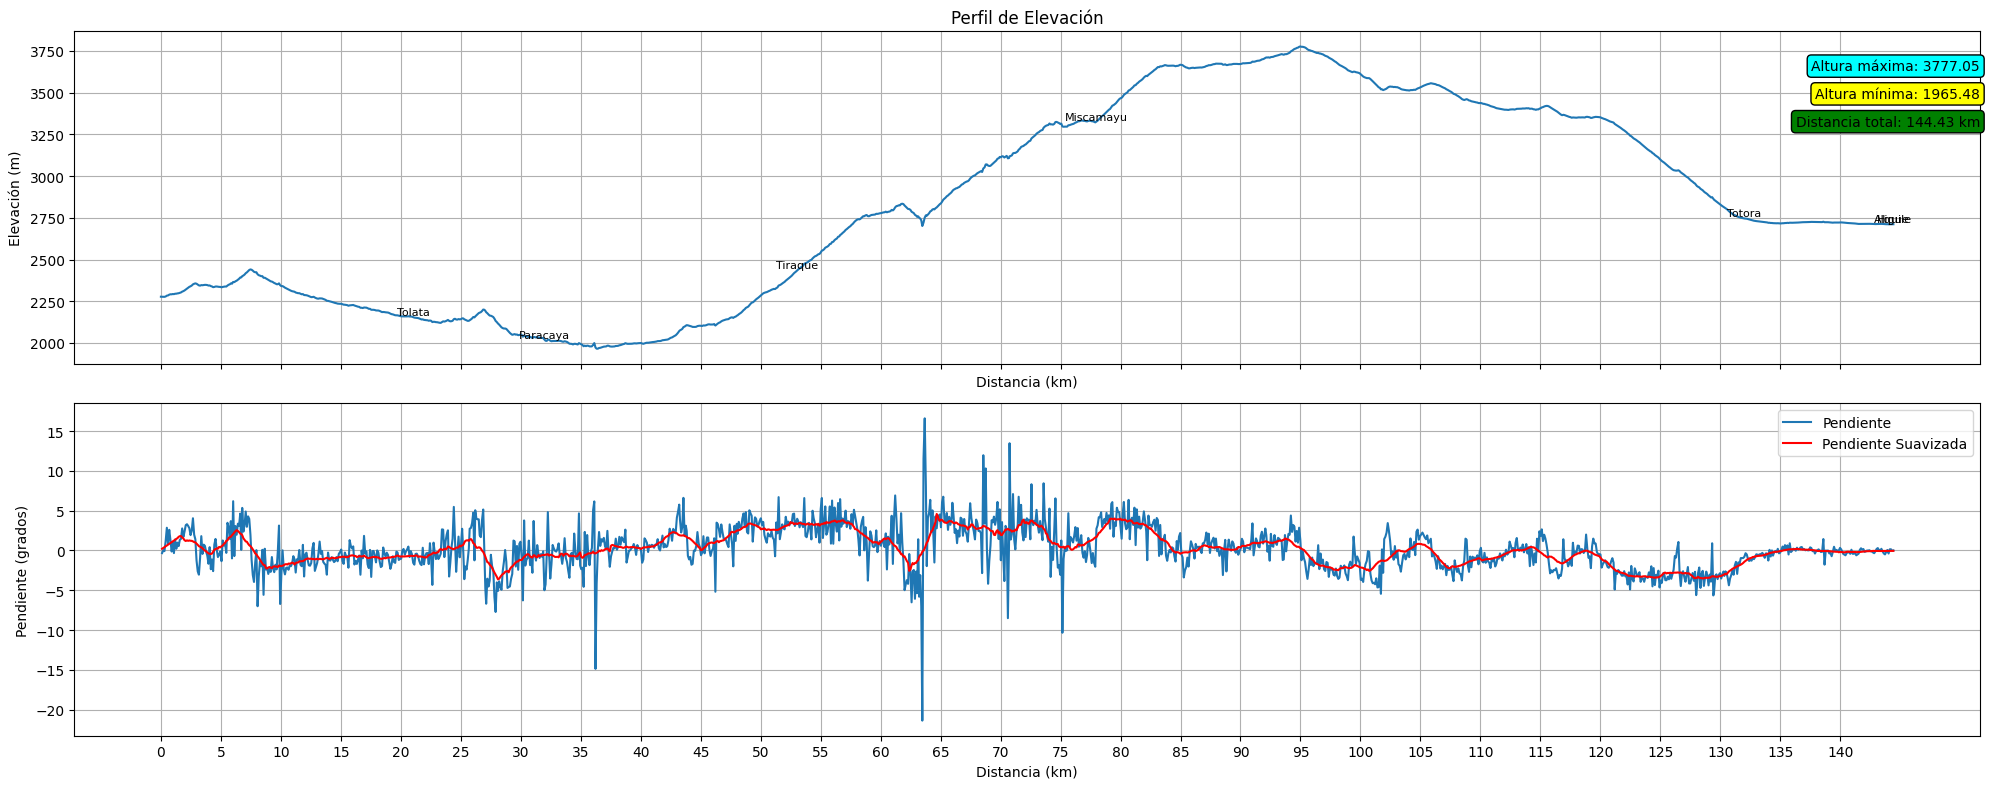

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, sqrt, atan2, radians, degrees, tan, atan
from scipy.signal import savgol_filter
from geopy.geocoders import Nominatim

def find_assistance_points(distances, slopes, battery_range):

  assistance_points = []
  remaining_range = battery_range

  start_idx = 0
  uphill_dist = 0

  for i in range(len(distances)-1):

    if slopes[i] <= 0 or slopes[i] < 1:
      # Reiniciar distancia si pendiente es <= 0 o < 2 grados
      start_idx = i+1
      uphill_dist = 0

    else:
      uphill_dist += distances[i] - distances[start_idx]

      if uphill_dist >= 1 and remaining_range < distances[-1] - distances[i]:
         assistance_points.append(i)
         remaining_range = battery_range - (distances[-1] - distances[i])

  return assistance_points

def suggest_relay_points(distances, interval=10):
    relay_points = []
    dist_covered = 0

    for i in range(len(distances)):
        if dist_covered >= interval:
            relay_points.append(i)
            dist_covered = 0

        dist_covered += distances[i] - distances[i-1]

    return relay_points

def gps2meter(long, lat):
    R_E = 6.3781 * 10 ** 6
    lat2meter = 111.3199 * 10 ** 3
    equator_circ = 2 * R_E * np.pi

    x, y = [0], [0]
    for i in range(len(long) - 1):
        long_m = (long[i + 1] - long[i]) * equator_circ * np.cos(np.deg2rad(lat[i + 1])) / 360 + x[-1]
        x.append(long_m)
        y.append((lat[i + 1] - lat[i]) * lat2meter + y[-1])

    return x, y

def curvature_cal(x, y):
    z = np.zeros(len(x))
    track = np.transpose(np.array([x, y, z]))
    L, curvature, k = [0], [0], np.array([[0, 0, 0]])

    for i in range(len(x) - 2):
        R, k_i = circumcenter(track[i, :], track[i + 1, :], track[i + 2, :])
        k = np.append(k, [np.transpose(k_i)], axis=0)
        L.append(L[i] + np.linalg.norm(track[i, :] - track[i - 1, :]))
        sign = np.sign(np.cross(track[i + 1, :] - track[i, :], k_i)[2])
        curvature.append(R ** (-1) * sign * (-1))

    return L, curvature, k


with open('/content/ruta2.txt') as f:
    data = json.load(f)

lats = [p['location']['lat'] for p in data['elevations']]
lons = [p['location']['lng'] for p in data['elevations']]

x, y = gps2meter(lons, lats)


distances, elevations = [0], []
for i in range(1, len(data['elevations'])):
    lat1, lon1 = lats[i - 1], lons[i - 1]
    lat2, lon2 = lats[i], lons[i]
    dlat, dlon = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    d = 6371 * c
    distance = distances[-1] + d
    distances.append(distance)
    elevations.append(data['elevations'][i]['elevation'])

distances = distances[:-1]

_, curvatures, k = curvature_cal(x, y)


elev_diff = np.diff(elevations)
dist_diff = np.diff(distances) * 1000
slopes = np.degrees(np.arctan2(elev_diff, dist_diff))

window = 25
slopes_smooth = savgol_filter(slopes, window, 1)


max_slope = np.max(slopes_smooth)
print(f"Pendiente máxima: {max_slope:.2f} grados")


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
ax1.plot(distances, elevations)


#------------------------------
ax1.set_title('Perfil de Elevación')
ax1.set_xlabel('Distancia (km)')
ax1.set_ylabel('Elevación (m)')
ax1.grid()

ax2.plot(distances[1:], slopes, label='Pendiente')
ax2.plot(distances[1:], slopes_smooth, color='red', label='Pendiente Suavizada')
ax2.legend()
ax2.set_xlabel('Distancia (km)')
ax2.set_ylabel('Pendiente (grados)')
ax2.set_xticks(np.arange(0, distances[-1], 5))
ax2.grid()


max_elev = max(elevations)
min_elev = min(elevations)
dist_text = 'Distancia total: ' + str(round(distances[-1], 2)) + ' km'
ax1.annotate('Altura máxima: ' + str(round(max_elev, 2)), xy=(1, 1), xycoords='axes fraction', xytext=(0, -20),
             textcoords='offset points', ha='right', va='top', bbox=dict(boxstyle='round', fc='cyan'))
ax1.annotate('Altura mínima: ' + str(round(min_elev, 2)), xy=(1, 1), xycoords='axes fraction', xytext=(0, -40),
             textcoords='offset points', ha='right', va='top', bbox=dict(boxstyle='round', fc='yellow'))
ax1.annotate(dist_text, xy=(1, 1), xycoords='axes fraction', xytext=(0, -60), textcoords='offset points', ha='right',
             va='top', bbox=dict(boxstyle='round', fc='green'))

'''
# Anotar ubicaciones automáticamente
geolocator = Nominatim(user_agent="localidades_cercanas")

for distance in locations.values():
    idx = np.argmin(np.abs(np.array(distances) - distance))
    lat, lon = lats[idx], lons[idx]
    location = geolocator.reverse((lat, lon), exactly_one=True)
    if location:
        address = location.raw.get('address', {})
        municipality = address.get('city') or address.get('town') or address.get('village') or address.get('country')
        if municipality:
            ax1.text(distances[idx], elevations[idx], municipality, ha='center', va='bottom', fontsize=8)
'''
locations = {'Tolata': 21, 'Paracaya': 32, 'Tiraque': 53, 'Miscamayu': 78, 'Totora': 132, 'Higue': 157, 'Alquile': 200}
for name, distance in locations.items():
    idx = np.argmin(np.abs(np.array(distances) - distance))
    ax1.text(distances[idx], elevations[idx], name, ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

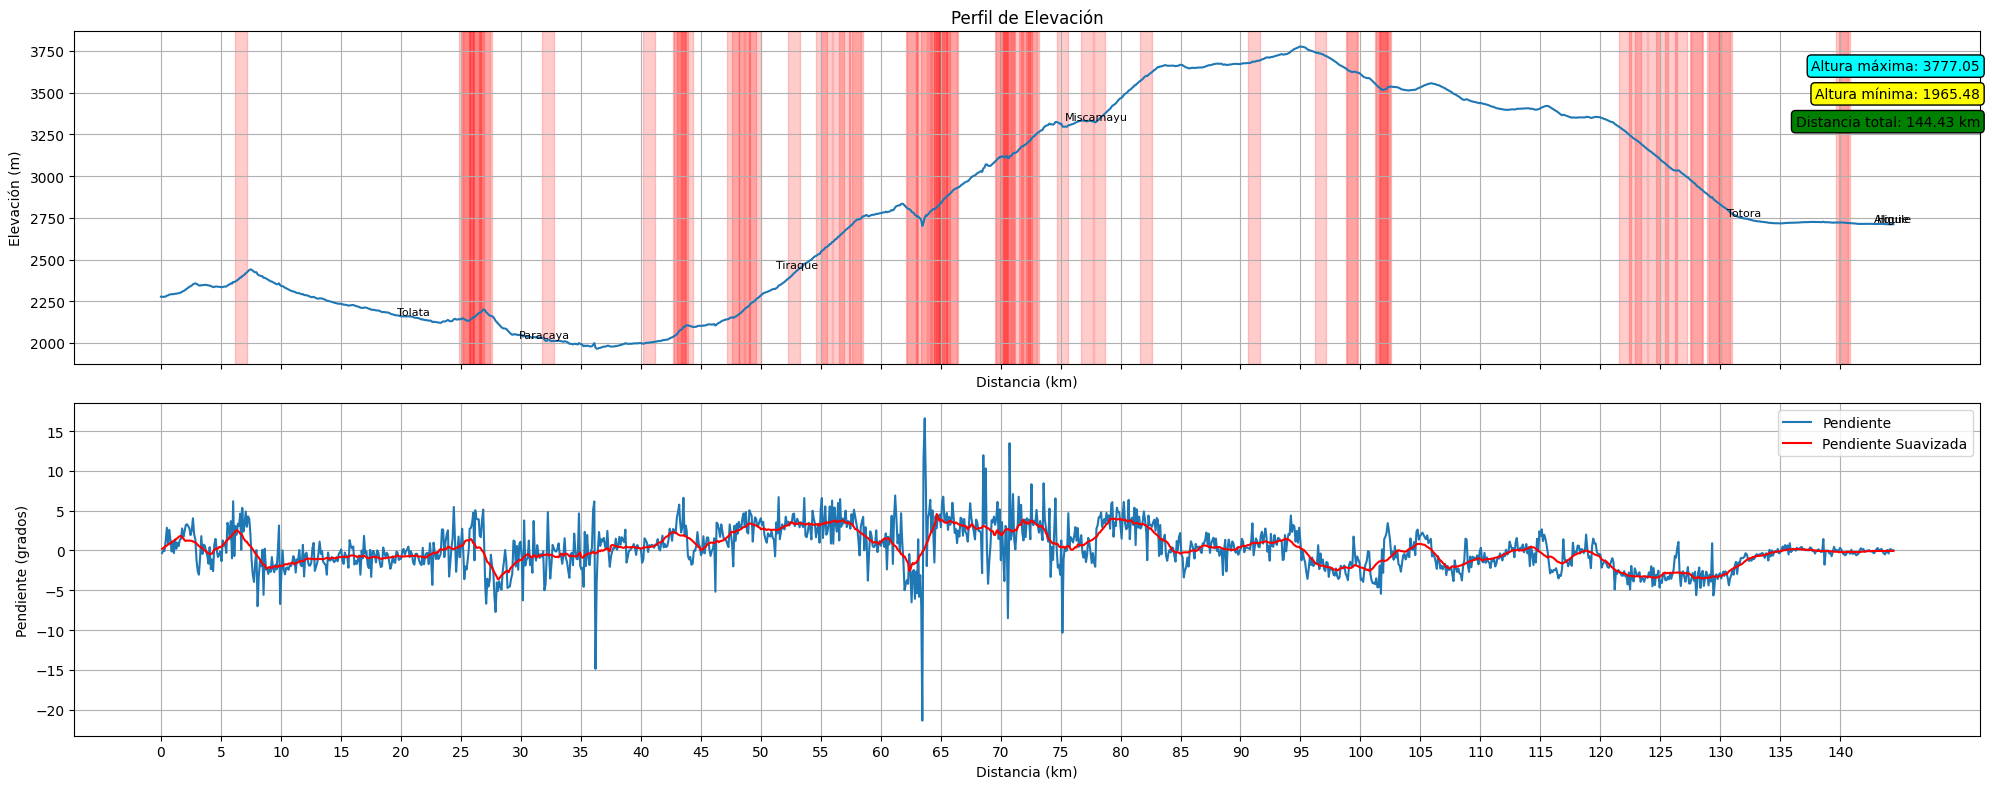

In [ ]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
ax1.plot(distances, elevations)
for i, c in enumerate(curvatures):
    if abs(c) > 0.01:  # umbral de curvatura
        ax1.axvspan(distances[i - 5], distances[i + 5], alpha=0.2, color='red')

ax1.set_title('Perfil de Elevación')
ax1.set_xlabel('Distancia (km)')
ax1.set_ylabel('Elevación (m)')
ax1.grid()

ax2.plot(distances[1:], slopes, label='Pendiente')
ax2.plot(distances[1:], slopes_smooth, color='red', label='Pendiente Suavizada')
ax2.legend()
ax2.set_xlabel('Distancia (km)')
ax2.set_ylabel('Pendiente (grados)')
ax2.set_xticks(np.arange(0, distances[-1], 5))
ax2.grid()


max_elev = max(elevations)
min_elev = min(elevations)
dist_text = 'Distancia total: ' + str(round(distances[-1], 2)) + ' km'
ax1.annotate('Altura máxima: ' + str(round(max_elev, 2)), xy=(1, 1), xycoords='axes fraction', xytext=(0, -20),
             textcoords='offset points', ha='right', va='top', bbox=dict(boxstyle='round', fc='cyan'))
ax1.annotate('Altura mínima: ' + str(round(min_elev, 2)), xy=(1, 1), xycoords='axes fraction', xytext=(0, -40),
             textcoords='offset points', ha='right', va='top', bbox=dict(boxstyle='round', fc='yellow'))
ax1.annotate(dist_text, xy=(1, 1), xycoords='axes fraction', xytext=(0, -60), textcoords='offset points', ha='right',
             va='top', bbox=dict(boxstyle='round', fc='green'))

locations = {'Tolata': 21, 'Paracaya': 32, 'Tiraque': 53, 'Miscamayu': 78, 'Totora': 132, 'Higue': 157, 'Alquile': 200}
for name, distance in locations.items():
    idx = np.argmin(np.abs(np.array(distances) - distance))
    ax1.text(distances[idx], elevations[idx], name, ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

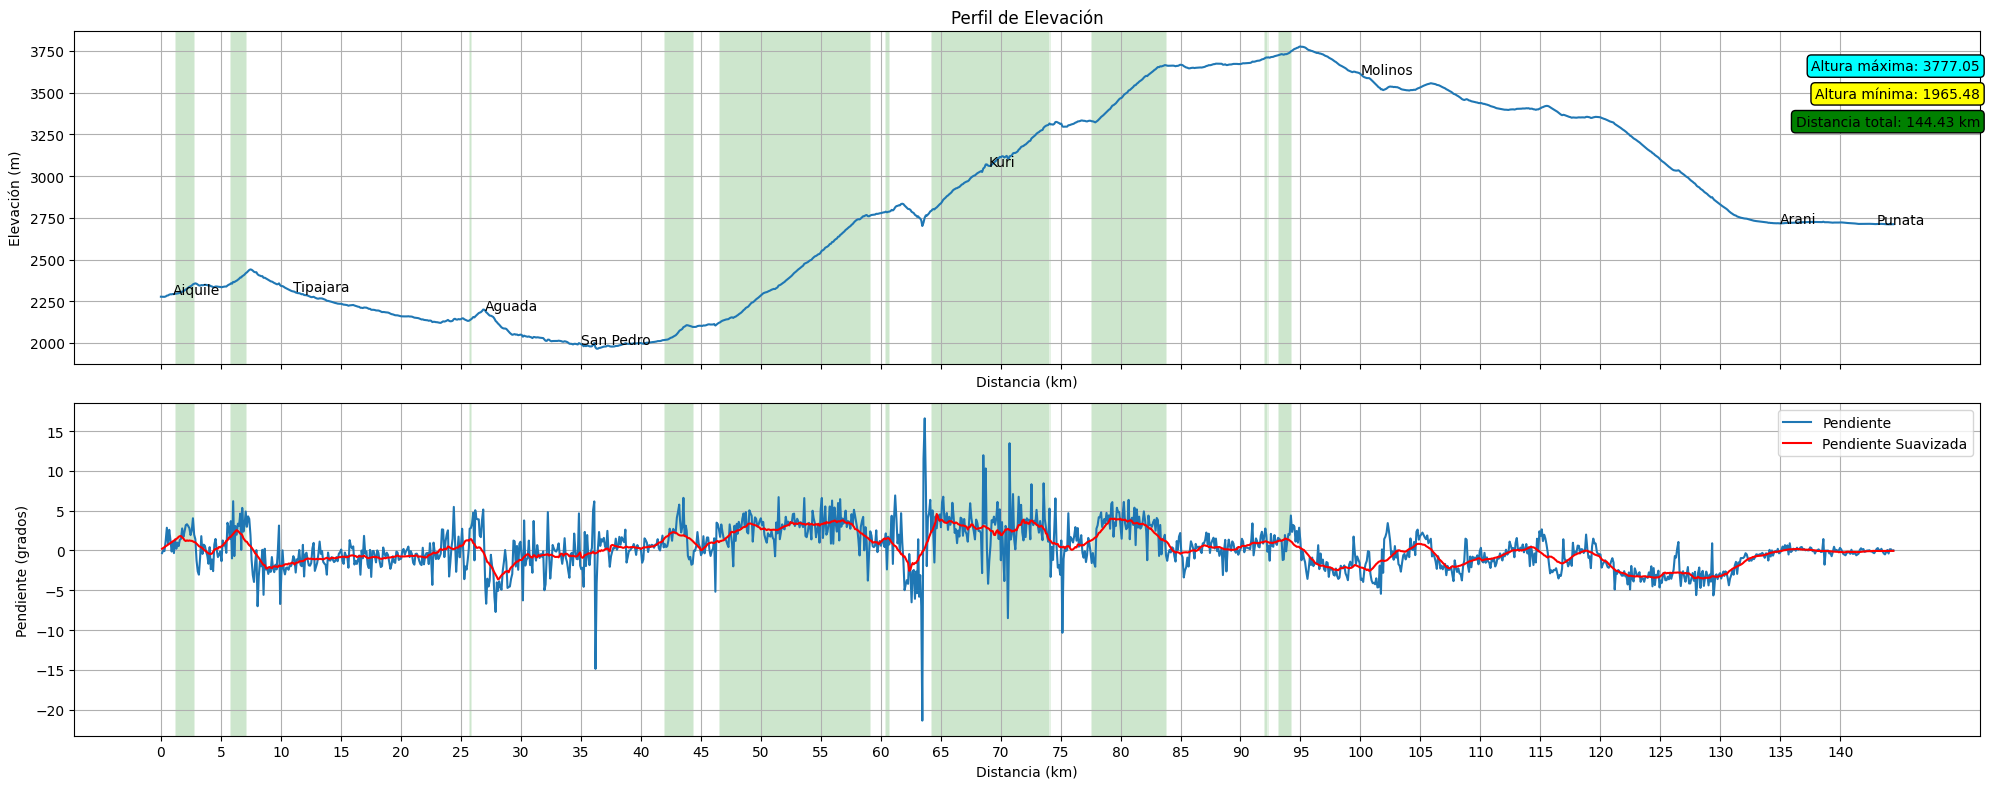

In [ ]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
ax1.plot(distances, elevations)

#-------------------
# Encontrar puntos de asistencia
battery_range = 1
assist_points = find_assistance_points(distances, slopes_smooth, battery_range)

# Sugerir puntos de relevo cada 30km
relay_points = suggest_relay_points(distances, 30)

# Puntos de relevo
for i in relay_points:
   ax1.axvspan(distances[i-5], distances[i+5], facecolor='green', alpha=0.1)


# Puntos de asistencia
for i in assist_points:
   ax1.axvspan(distances[i-1], distances[i+1], facecolor='green', alpha=0.1)
   ax2.axvspan(distances[i-1], distances[i+1], facecolor='green', alpha=0.1)

#------------------------------
ax1.set_title('Perfil de Elevación')
ax1.set_xlabel('Distancia (km)')
ax1.set_ylabel('Elevación (m)')
ax1.grid()

ax2.plot(distances[1:], slopes, label='Pendiente')
ax2.plot(distances[1:], slopes_smooth, color='red', label='Pendiente Suavizada')
ax2.legend()
ax2.set_xlabel('Distancia (km)')
ax2.set_ylabel('Pendiente (grados)')
ax2.set_xticks(np.arange(0, distances[-1], 5))
ax2.grid()

# Annotate maximum and minimum elevations
max_elev = max(elevations)
min_elev = min(elevations)
dist_text = 'Distancia total: ' + str(round(distances[-1], 2)) + ' km'
ax1.annotate('Altura máxima: ' + str(round(max_elev, 2)), xy=(1, 1), xycoords='axes fraction', xytext=(0, -20),
             textcoords='offset points', ha='right', va='top', bbox=dict(boxstyle='round', fc='cyan'))
ax1.annotate('Altura mínima: ' + str(round(min_elev, 2)), xy=(1, 1), xycoords='axes fraction', xytext=(0, -40),
             textcoords='offset points', ha='right', va='top', bbox=dict(boxstyle='round', fc='yellow'))
ax1.annotate(dist_text, xy=(1, 1), xycoords='axes fraction', xytext=(0, -60), textcoords='offset points', ha='right',
             va='top', bbox=dict(boxstyle='round', fc='green'))

locations = {
  1: 'Aiquile',
  11: 'Tipajara',
  27: 'Aguada',
  35: 'San Pedro',
  69: 'Kuri',
  100: 'Molinos',
  135: 'Arani',
  143: 'Punata'
}
for distance, name in locations.items():
  idx = min(range(len(distances)), key=lambda i: abs(distances[i]-distance))
  ax1.text(distance, elevations[idx], name)

plt.tight_layout()
plt.show()

In [ ]:
import folium
# Calcular puntos de curva
high_curvature_points = []

for i, c in enumerate(curvatures):
   if abs(c) > 0.01:
      high_curvature_points.append(i)
# Crear mapa centrado en el punto medio
lat_mean = np.mean(lats)
lon_mean = np.mean(lons)
map = folium.Map(location=[lat_mean, lon_mean], zoom_start=13)

# Agregar puntos del recorrido
for lat, lon in zip(lats, lons):
    folium.CircleMarker([lat, lon],
                        radius=1,
                        color='blue',
                        fill=True).add_to(map)

# Agregar puntos de asistencia
for i in assist_points:
   folium.CircleMarker([lats[i], lons[i]],
                       radius=3,
                       color='green',
                       fill=True).add_to(map)
 # Agregar puntos de curva
for i in high_curvature_points:
   folium.CircleMarker([lats[i], lons[i]],
                       radius=4,
                       color='red',
                       fill=True).add_to(map)
# Guardar mapa html
map.save('mapa2.html')